# A Beginner's Guide to tree-sitter

> From AI3602 with love ❤️

In this tutorial, we briefly illustrate how we can traverse a tree-sitter AST.

## Introduction

We consider this Java program

```java
public class MyClass {
    public static void MyMethod() {
        System.out.println("Hello world!");
    }
}
```

and its corresponding AST (visualized by [tree-sitter playground](https://tree-sitter.github.io/tree-sitter/playground)). Note that each node in this AST has a type (e.g., the root node is of type `program`, and there are also nodes of other types such as `identifier`, `method_invocation` and `string_literal`).

```plaintext
program [0, 0] - [5, 0]
└── class_declaration [0, 0] - [4, 1]
    ├── modifiers [0, 0] - [0, 6]
    ├── name: identifier [0, 13] - [0, 20]
    └── body: class_body [0, 21] - [4, 1]
        └── method_declaration [1, 4] - [3, 5]
            ├── modifiers [1, 4] - [1, 17]
            ├── type: void_type [1, 18] - [1, 22]
            ├── name: identifier [1, 23] - [1, 31]
            ├── parameters: formal_parameters [1, 31] - [1, 33]
            └── body: block [1, 34] - [3, 5]
                └── expression_statement [2, 8] - [2, 43]
                    └── method_invocation [2, 8] - [2, 42]
                        ├── object: field_access [2, 8] - [2, 18]
                        │   ├── object: identifier [2, 8] - [2, 14]
                        │   └── field: identifier [2, 15] - [2, 18]
                        ├── name: identifier [2, 19] - [2, 26]
                        └── arguments: argument_list [2, 26] - [2, 42]
                            └── string_literal [2, 27] - [2, 41]
                                └── string_fragment [2, 28] - [2, 40]
```

In [1]:
import tree_sitter
from utils import pprint_tree

code = """
public class MyClass {
    public static void MyMethod() {
        System.out.println("Hello world!");
    }
}
"""

In [2]:
# Load the tree-sitter-python library
parser = tree_sitter.Parser()
parser.set_language(tree_sitter.Language("./parser/my-languages.so", "java"))

# parse the code
tree = parser.parse(code.encode())
root = tree.root_node


d:\Software\anaconda3\envs\pytorch\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


The root of a `tree-sitter-java` AST always have the type `program`. In this AST, the root node contains only one child (which is the class declaration).

In [3]:
print("root node type:", root.type)  # "program"
print("root node child count:", root.child_count)  # 1

root node type: program
root node child count: 1


We can access the children of a node by `node.children[idx]`. `root.children[0]` should give us the class declaration node, which is the first (and only) child of the root `program` node.

Observe that the class declaration node has 4 children.

In [4]:
class_decl_node = root.children[0]
print("child 0 of root node:", class_decl_node.type)  # "class_declaration"
print("class_decl_node child count:", class_decl_node.child_count)  # 4

child 0 of root node: class_declaration
class_decl_node child count: 4


If we pretty-print this tree, we can see the 4 children of the `class_declaration` are respectively

1. A `modifiers` node. This corresponds to the keyword `public`.
2. A `class` node. This is simply the keyword `class`.
3. An `identifier` node. This is the node for the name of the class `MyClass` (an identifier).
4. A `class_body` node. This node corresponds to the main body of the class.



In [5]:
for i, child in enumerate(class_decl_node.children):
    print(f"child {i} of class_decl_node:", child.type)

print(pprint_tree(root))

child 0 of class_decl_node: modifiers
child 1 of class_decl_node: class
child 2 of class_decl_node: identifier
child 3 of class_decl_node: class_body
program
└── class_declaration
    ├── modifiers
    │   └── public
    ├── class
    ├── identifier (MyClass)
    └── class_body
        ├── {
        ├── method_declaration
        │   ├── modifiers
        │   │   ├── public
        │   │   └── static
        │   ├── void_type (void)
        │   ├── identifier (MyMethod)
        │   ├── formal_parameters
        │   │   ├── (
        │   │   └── )
        │   └── block
        │       ├── {
        │       ├── expression_statement
        │       │   ├── method_invocation
        │       │   │   ├── field_access
        │       │   │   │   ├── identifier (System)
        │       │   │   │   ├── .
        │       │   │   │   └── identifier (out)
        │       │   │   ├── .
        │       │   │   ├── identifier (println)
        │       │   │   └── argument_list
        │       │   │  

Assume we now want to extract the class name `MyClass`, since we already know that the `identifier` node for `MyClass` is the third children of `class_declaration`, we can directly access it by its index.

In [6]:
name_node = class_decl_node.children[2]
print("name_node type:", name_node.type)
print("name_node text:", name_node.text.decode())

name_node type: identifier
name_node text: MyClass


This does not look very difficult, is it? However, accessing children by its index is **NOT recommended**!

See the example below. `another_code` is also a valid Java program and it produces a valid Java AST. However, there is no `public` modifiers before the class declaration, and hence the `class_declaration` node only contains 3 children!

If we continue to access the identifier node by its index, we would get incorrect results.

In [7]:
another_code = """
class Boom {
    public static void Foo() {
        System.out.println("Explode!");
    }
}
"""

another_tree = parser.parse(another_code.encode())
another_root = another_tree.root_node

# this class_declaration node has ONLY 3 CHILDREN
print(
    "number of children of class_declaration node:", another_root.children[0].child_count
)
for i, child in enumerate(another_root.children[0].children):
    print(f"child {i} of class_declaration node:", child.type)

# we can no longer access the name node using index 2
another_cls_decl_node = another_root.children[0]
not_the_name_node = another_cls_decl_node.children[2]

# the child node on index 2 is now the class_body, instead of the name node!
print("not_the_name_node type:", not_the_name_node.type)

number of children of class_declaration node: 3
child 0 of class_declaration node: class
child 1 of class_declaration node: identifier
child 2 of class_declaration node: class_body
not_the_name_node type: class_body


This is because the `modifier` child in the `class_declaration` node is OPTIONAL. I.e., some `class_declaration` nodes might not contain any modifiers.

Then how can we precisely access the name node?

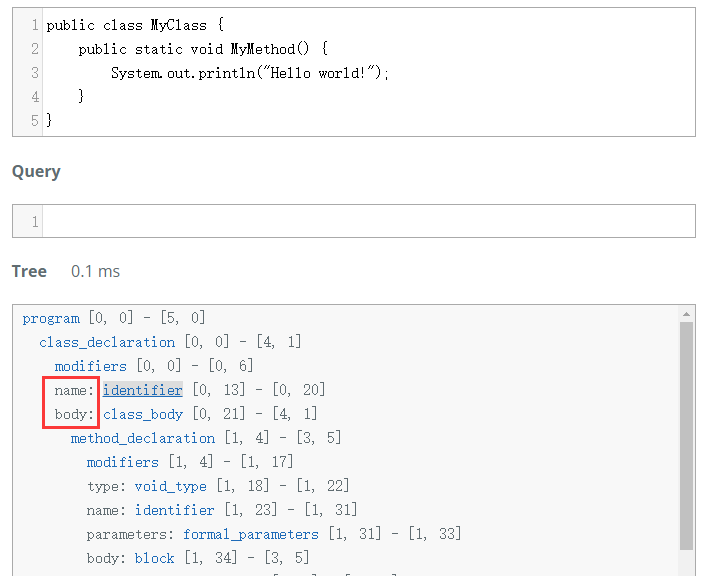

If we look at the AST visualization on tree-sitter playground, we can find that some child nodes contain "prefixes" (e.g., `name:` and `body:`).

These prefixes are the **names** of a certain child. While the index of a children might change, its name will never change. That is, the name child of the `class_declaration` node always has the name `name`, and the main body of the class declaration always has the name `body`.

We can then access the children by their names, which is will give us more stable results.

In [8]:
name_node = class_decl_node.child_by_field_name("name")
print("name_node type:", name_node.type)
print("text:", name_node.text.decode())

another_name_node = another_cls_decl_node.child_by_field_name("name")
print("another_name_node type:", another_name_node.type)
print("text:", another_name_node.text.decode())

name_node type: identifier
text: MyClass
another_name_node type: identifier
text: Boom


Therefore the names provide a more robust way of accessing child nodes. In addition to `child_by_field_name`, there is also a method `children_by_field_name`, which returns a list of child nodes. This can be useful when multiple child nodes share a same name.

In [9]:
vardecl_code = "Int a, b;"  # put this line into playground to visualize it!

vardecl_tree = parser.parse(vardecl_code.encode())
vardecl_root = vardecl_tree.root_node
local_var_decl_nodes = vardecl_root.children[0]

declarators = local_var_decl_nodes.children_by_field_name("declarator")
print(f"number of declarators: {len(declarators)}")

for declarator in declarators:
    print("declarator type:", declarator.type)
    print("declarator text:", declarator.text.decode())
    print()

number of declarators: 2
declarator type: variable_declarator
declarator text: a

declarator type: variable_declarator
declarator text: b



## Grammar.js

But then comes another question: how do we know what types of children the node contains?

1. The intuitive (but less recommended) way is to pretty print the tree, or use the playground. However, hand-crafted code might miss certain code structures. While in general this method will give us the right answer (for most of the time), it might not be able to cover certain corner cases.
2. A more advanced and complete way is to refer to the `grammar.js` at [tree-sitter-java GitHub Repository](https://github.com/tree-sitter/tree-sitter-java/blob/master/grammar.js).

tree-sitter supports multiple languages, and for each language, there is a `grammar.js` that specifies the grammatical structure of the programming language. This `grammar.js` file also defines the structure of the AST.

For example, for the `class_declaration` node in tree-sitter-java, the corresponding grammar is

```js
// https://github.com/tree-sitter/tree-sitter-java/blob/master/grammar.js#L879
class_declaration: $ => seq(
    optional($.modifiers),
    'class',
    field('name', $.identifier),
    optional(field('type_parameters', $.type_parameters)),
    optional(field('superclass', $.superclass)),
    optional(field('interfaces', $.super_interfaces)),
    optional(field('permits', $.permits)),
    field('body', $.class_body),
),
```

It means a `class_declaration` node is a sequence (`seq`) at most 8 nodes, among which the `'class'` keyword, the `name` node, the `body` node are mandatory, and the other 5 nodes are optional.

Observe that `field('name', $.identifier)` defines a child field with the name `name` and type `identifier`. This means that a `class_declaration` node will *always* has a child whose name is `name`, and this `name` child will *always* has a type of `identifier`. Therefore, we can use `node.child_by_field_name("name")` to access this child, and we can safely expect a node of type `identifier`.

Similarly, for a `while` statement,

```js
// https://github.com/tree-sitter/tree-sitter-java/blob/master/grammar.js#L672
while_statement: $ => seq(
    'while',
    field('condition', $.parenthesized_expression),
    field('body', $.statement),
),
```

It contains 3 nodes, a `'while'` keyword, a loop condition (with type `parenthesis_expression`) named `condition`, and a loop body (with type `statement`) named `body`.

Using this grammar specification, we can infer the number of children and their types for each AST node. Then we can access the corresponding child with either `node.child_by_field_name()` or `node.children[i]`.


## Wrapping Up

Combining what we have introduced so far, assume we want to implement a function that extracts all class names.

We already know that the class name is stored as an `identifier`, under `class_declaration`, and can be accessed by name `name`.

Therefore we can use a DFS to traverse all nodes

- If the current node type is `class_declaration`, we can then access its name by its `name` field.
- We then visit the children of current node recursively.

In [10]:
def find_class_names(node: tree_sitter.Node):

    # process class_declaration nodes
    if node.type == "class_declaration":
        name_node = node.child_by_field_name("name")
        assert name_node.type == "identifier"

        print(f"Class name found: {name_node.text.decode()}")

    # recursively visit children
    for child in node.children:
        find_class_names(child)


final_code = """
public class Fruit {
    // No, don't ask me why a fruit only has a sourness property :P
	public bool isSour() {}
}

public class Orange extends Fruit {
	public bool isSour() { return true; }
}

@override
public class Apple extends Fruit {
    public bool isSour() { return false; }
}
"""

final_tree = parser.parse(final_code.encode())
final_root = final_tree.root_node
assert not final_root.has_error

find_class_names(final_root)


Class name found: Fruit
Class name found: Orange
Class name found: Apple
